## 1.0 Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import random
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import RobustScaler, OneHotEncoder
# Definindo a semente
random.seed(123)

## 2.0 Funções auxiliares

In [2]:
# Metadados referente ao conjunto de dados
def generate_metadata(dataframe):
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os metadados serão gerados.
    :return: DataFrame contendo metadados.
    """

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata=metadata.sort_values(by='percent_nulos',ascending=False)
    metadata = metadata.reset_index(drop=True)

    return metadata

def remove_highly_correlated_features(df, threshold):

  # Select numerical columns only for correlation calculation
  numerical_df = df.select_dtypes(include=np.number)
  corr_matrix = numerical_df.corr().abs()
    
  # Calculate the correlation matrix
  #corr_matrix = df.corr().abs()

  # Select the upper triangle of the correlation matrix
  upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

  # Identify columns to drop based on the threshold
  to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

  # Drop the columns
  df_reduced = df.drop(columns=to_drop)

  return df_reduced, to_drop

def amostragem(df,tamanho_amostra):
  amostra = df.sample(n=tamanho_amostra,random_state=42)
  return amostra

def variancia(table_01, threshold):
    cat_attributes = table_01.select_dtypes(include='object')
    num_attributes = table_01.select_dtypes(exclude='object')

    # Preparação dos dados

    # Create a label encoder
    label_encoder = LabelEncoder()
    #OH_enconder = OneHotEncoder(drop='first')

    # Fit and transform the data
    for obj in cat_attributes.columns:
        cat_attributes[obj] = label_encoder.fit_transform(cat_attributes[obj].astype(str))

    table_final = pd.concat([num_attributes,cat_attributes],axis=1)

    # Scaler
    scaler = RobustScaler()

    table_final_02 = scaler.fit_transform(table_final)

    table_final_03 = pd.DataFrame(table_final_02,columns=table_01.columns)

    selector = VarianceThreshold(threshold)
    selector.fit_transform(table_final_03)

    # Colunas selecionadas
    selected_features = table_final_03.columns[selector.get_support()]

    # Manter apenas features selecionadas
    table_final_03_select01 = table_final_03[selected_features]

    return table_final_03_select01

def feature_importance(df):
  # Amostragem
  amostra = df.sample(n=8000,random_state=42)
  X = amostra.drop(columns=['Target','ClientId','DataUltimaTransacao','DataExtracao','DiasDesdeUltTransacao'])
  y = amostra.Target
  id = amostra.ClientId

  # Tratamento de missings
  from sklearn.impute import SimpleImputer
  imputer_num = SimpleImputer(strategy='mean')
  imputer_cat = SimpleImputer(strategy='most_frequent')
  cat_attributes = X.select_dtypes(include='object')
  num_attributes = X.select_dtypes(exclude='object')
  num_imputed = imputer_num.fit_transform(num_attributes)
  cat_imputed = imputer_cat.fit_transform(cat_attributes)

  df_num = pd.DataFrame(num_imputed,columns=num_attributes.columns)
  df_cat = pd.DataFrame(cat_imputed,columns=cat_attributes.columns)

  # Aplicação de encoding
  label_encoder = LabelEncoder()

  # Fit and transform the data
  for obj in cat_attributes.columns:
      df_cat[obj] = label_encoder.fit_transform(df_cat[obj].astype(str))

  y.index = df_num.index
  id.index = df_num.index
  df_tratado = pd.concat([df_num,df_cat,y],axis=1)

  X = df_tratado.drop(columns=['Target'])
  y = df_tratado.Target

  # Treino utilizando o Gradient Boosting
  algoritmo = GradientBoostingClassifier(random_state=0)
  algoritmo.fit(X,y)
  feature_importances = algoritmo.feature_importances_

  # Importância das variáveis de acordo com o algoritmo

  df_importancias = pd.DataFrame(X.columns,columns=['Variável'])
  df_importancias['Importância'] = feature_importances

  df_importancias = df_importancias[df_importancias['Importância'] > 0.05] ##selecionar o % de importancia em relacao ao top1
  # Ordenar o DataFrame pelo valor de importância em ordem decrescente
  df_importancias = df_importancias.sort_values(by='Importância', ascending=False)
    
  # Crie o gráfico de barras
  plt.figure(figsize=(10, 6))
  plt.barh(df_importancias['Variável'], df_importancias['Importância'], color='skyblue')
  plt.xlabel('Importância')
  plt.ylabel('Variável')
  plt.title('Importância das Variáveis')
  plt.gca().invert_yaxis()  # Inverte o eixo y para mostrar a variável mais importante no topo
  plt.grid(axis='x', linestyle='--', alpha=0.6)
  plt.tight_layout()
  plt.show()

  return df_importancias

def vars_selection(df,percentual_preenchimento,threshold,tamanho_amostragem):
  variaveis_publico = df.filter(like='Target').columns.to_list()
  df_aux = df.loc[:, ~df.columns.str.endswith('Target')]
  amostra = amostragem(df_aux, tamanho_amostragem)

  metadata_df = generate_metadata(amostra)

  # Avaliar preenchimento
  vars = metadata_df[metadata_df.percent_nulos <= percentual_preenchimento]['nome_variavel']
  # Avaliar correlaçao
  df_reduced, dropped_features = remove_highly_correlated_features(amostra[vars], threshold=threshold)
  # Avaliar variância - remover variáveis constantes
  table_01 = variancia(df_reduced, threshold=0)

  vars_selected = table_01.columns.to_list()
  vars_df_final = vars_selected + variaveis_publico
  df_selected = df[vars_df_final]

  df_importancias = feature_importance(df_selected)


  return df_importancias



## 3.0 Leitura dos dados

In [3]:
df_churn = pd.read_csv('../db_churn_2.csv')
df_churn = df_churn.drop(columns='Unnamed: 0')
df_churn.head()

,ClientId,DataExtracao,Score_Credito,Estado,Gênero,Idade,Tempo_Cliente,Limite_Credito_Mercado,Qte_Categorias,Usa_Cartao_Credito,Programa_Fidelidade,Sum_Pedidos_Acumulados,DataUltimaTransacao,DiasDesdeUltTransacao,Target
0,345568,2019-06-30,619,São Paulo,Feminino,42,2,0.0000,1,1,1,422.287000,2019-09-14,46,1
1,345569,2019-06-30,608,Rio de Janeiro,Feminino,41,1,838.0786,1,0,1,468.927417,2019-10-05,25,0
2,345570,2019-06-30,502,São Paulo,Feminino,42,8,1596.6080,3,1,0,474.714875,2019-08-20,71,1
3,345571,2019-06-30,699,São Paulo,Feminino,39,1,0.0000,2,0,0,390.944292,2019-10-21,9,0
4,345572,2019-06-30,850,Rio de Janeiro,Feminino,43,2,1255.1082,1,1,1,329.517083,2019-10-26,4,0


## 4.0 Split dos dados

In [4]:
abt = df_churn
from sklearn.model_selection import train_test_split

# Supondo que você tenha um dataframe df_churn

# Especificando a proporção de divisão (por exemplo, 80% treino, 20% teste)
proporcao_teste = 0.2

# Dividindo o dataframe em conjunto de treino e teste
df_treino, df_teste = train_test_split(abt, test_size=proporcao_teste, random_state=42)


In [5]:
df_treino.columns

Index(['ClientId', 'DataExtracao', 'Score_Credito', 'Estado', 'Gênero',
       'Idade', 'Tempo_Cliente', 'Limite_Credito_Mercado', 'Qte_Categorias',
       'Usa_Cartao_Credito', 'Programa_Fidelidade', 'Sum_Pedidos_Acumulados',
       'DataUltimaTransacao', 'DiasDesdeUltTransacao', 'Target'],
      dtype='object')

## 5.0 Seleção de variáveis

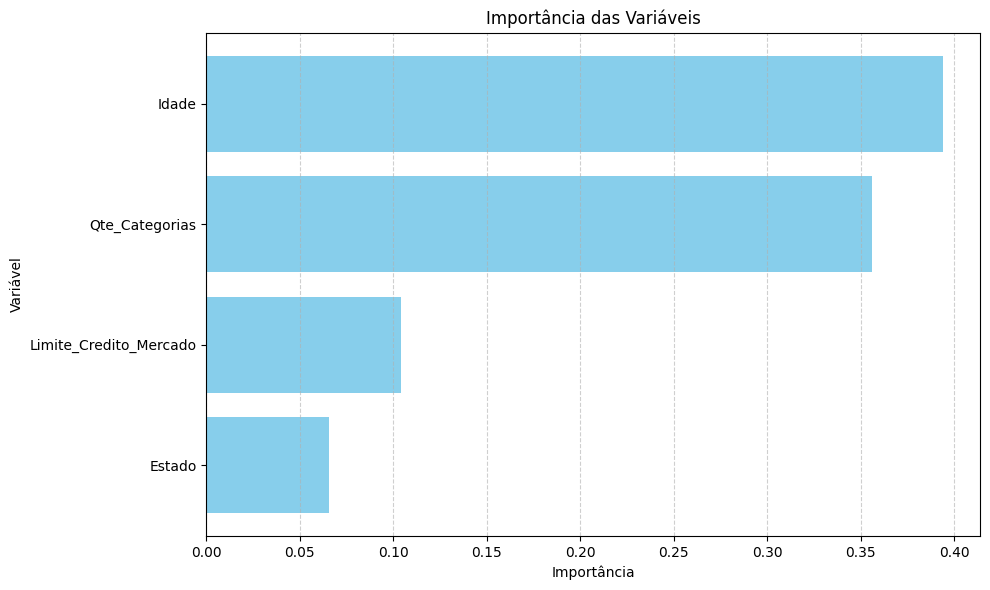

In [6]:
df_treino_selected = vars_selection(df_treino,percentual_preenchimento=80,threshold=0.5,tamanho_amostragem=8000)

In [7]:
# Manter apenas as variáveis selecionadas
vars_selected = df_treino_selected['Variável'].to_list()
vars_selected.append('ClientId')
vars_selected.append('Target')
df_treino[vars_selected].to_csv('../df_treino_vars_selected.csv')

In [8]:
# Realizar o mesmo procedimento na base de teste
vars_selected.remove('Target')
df_teste[vars_selected].to_csv('../df_teste_vars_selected.csv')

In [9]:
vars_selected = df_treino_selected['Variável'].to_list()
vars_selected.append('ClientId')
vars_selected.append('Target')
vars_selected

['Idade',
 'Qte_Categorias',
 'Limite_Credito_Mercado',
 'Estado',
 'ClientId',
 'Target']